In [2]:
# 1. Setup & Load Data
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties
import seaborn as sns

import re
import joblib
import torch
from wordcloud import WordCloud
from collections import Counter
from torch.utils.data import Dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix

from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [3]:
# Load dataset
ds = load_dataset("zabir-nabil/bangla_newspaper_dataset")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/170M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/170M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/171M [00:00<?, ?B/s]

data/valid-00000-of-00001.parquet:   0%|          | 0.00/118M [00:00<?, ?B/s]

data/test_1-00000-of-00001.parquet:   0%|          | 0.00/157M [00:00<?, ?B/s]

data/test_2-00000-of-00001.parquet:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/265506 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/61274 [00:00<?, ? examples/s]

Generating test_1 split:   0%|          | 0/81691 [00:00<?, ? examples/s]

Generating test_2 split:   0%|          | 0/495 [00:00<?, ? examples/s]

In [4]:
# For PyTorch
print(torch.cuda.is_available())  # True if GPU is available
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
Tesla T4


In [5]:
# Convert to pandas DataFrame (train split)
df = pd.DataFrame(ds['train'])
df.head()

,author,category,category_bn,published_date,modification_date,tag,comment_count,title,url,content,__index_level_0__
0,নিজস্ব প্রতিবেদক,bangladesh,বাংলাদেশ,"১২ জানুয়ারি ২০১৪, ১৮:৫১","১২ জানুয়ারি ২০১৪, ২২:৩০",সরকার,NaN,৪৯ মন্ত্রীর দপ্তর বণ্টন করে প্রজ্ঞাপন,http://www.prothom-alo.com/bangladesh/article/...,প্রধানমন্ত্রী শেখ হাসিনার নেতৃত্বাধীন নতুন মন্...,42879
1,ফেনী অফিস,bangladesh,বাংলাদেশ,"০২ ডিসেম্বর ২০১৫, ০১:২৭","০২ ডিসেম্বর ২০১৫, ০১:২৮","ফেনী,অপরাধ",0.0,ছাত্রলীগ নেতাদের দাওয়াত না দেওয়ায় অনুষ্ঠান পণ্ড!,http://www.prothom-alo.com/bangladesh/article/...,ফেনী সরকারি কলেজে স্নাতক প্রথম বর্ষের শিক্ষার্...,179679
2,মংলা (বাগেরহাট) প্রতিনিধি,bangladesh,বাংলাদেশ,"০৬ জুন ২০১৫, ০১:৫৮","০৬ জুন ২০১৫, ০১:৫৯","মোংলা,বাগেরহাট,খুলনা বিভাগ,বিশাল বাংলা",0.0,সাতক্ষীরা থেকে উদ্ধার করা কুমির সুন্দরবনে অবমুক্ত,http://www.prothom-alo.com/bangladesh/article/...,সাতক্ষীরার দেবহাটা থেকে গত বৃহস্পতিবার সকালে উ...,144842
3,বাঞ্ছারামপুর প্রতিনিধি,bangladesh,বাংলাদেশ,"৩১ অক্টোবর ২০১৬, ০১:০২","৩১ অক্টোবর ২০১৬, ০১:০৩","বাঞ্ছারামপুর,বিশাল বাংলা,অপরাধ",0.0,প্রধান আসামিকে গ্রেপ্তারের দাবি,http://www.prothom-alo.com/bangladesh/article/...,ব্রাহ্মণবাড়িয়ার বাঞ্ছারামপুরের দরিকান্দি ইউনিয়...,261163
4,-1,international,আন্তর্জাতিক,"২৬ আগস্ট ২০১৪, ০০:০৭","২৬ আগস্ট ২০১৪, ০০:০৭",আরব বিশ্ব,0.0,ফিলিস্তিনিদের অস্ত্র দেবে তেহরান,http://www.prothom-alo.com/international/artic...,ফিলিস্তিনিদের অস্ত্র দেওয়ার কাজে গতি বাড়াবে তে...,88191


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265506 entries, 0 to 265505
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   author             265506 non-null  object 
 1   category           265506 non-null  object 
 2   category_bn        265506 non-null  object 
 3   published_date     265506 non-null  object 
 4   modification_date  265506 non-null  object 
 5   tag                265506 non-null  object 
 6   comment_count      178569 non-null  float64
 7   title              265506 non-null  object 
 8   url                265506 non-null  object 
 9   content            265506 non-null  object 
 10  __index_level_0__  265506 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 22.3+ MB


In [6]:
# 2. Preprocess Data

In [7]:
# Filter out very short articles (content length < 1000)
df['content_length'] = df['content'].apply(len)
df = df[df['content_length'] >= 1000]

In [8]:
# Check category counts
category_counts = df['category_bn'].value_counts()
category_counts

,count
category_bn,
বাংলাদেশ,97736
খেলা,22390
আন্তর্জাতিক,13757
বিনোদন,13104
মতামত,9394
অর্থনীতি,7221
জীবনযাপন,6251
শিক্ষা,5558
বিজ্ঞান ও প্রযুক্তি,5298


In [9]:
# Keep only top 9 categories
top9_categories = category_counts.nlargest(9).index.tolist()
df = df[df['category_bn'].isin(top9_categories)]

In [10]:
df['category_bn'].value_counts()

,count
category_bn,
বাংলাদেশ,97736
খেলা,22390
আন্তর্জাতিক,13757
বিনোদন,13104
মতামত,9394
অর্থনীতি,7221
জীবনযাপন,6251
শিক্ষা,5558
বিজ্ঞান ও প্রযুক্তি,5298


In [11]:
# Keep only 'content' and 'category_bn' columns
df = df[['content', 'category_bn']]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180709 entries, 0 to 265505
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   content      180709 non-null  object
 1   category_bn  180709 non-null  object
dtypes: object(2)
memory usage: 4.1+ MB


In [13]:
# Randomly sample 10000 rows in total
sampled_df = df.sample(n=40000, random_state=42).reset_index(drop=True)

In [14]:
sampled_df['category_bn'].value_counts()

,count
category_bn,
বাংলাদেশ,21699
খেলা,4884
আন্তর্জাতিক,3031
বিনোদন,2929
মতামত,2108
অর্থনীতি,1641
জীবনযাপন,1332
শিক্ষা,1230
বিজ্ঞান ও প্রযুক্তি,1146


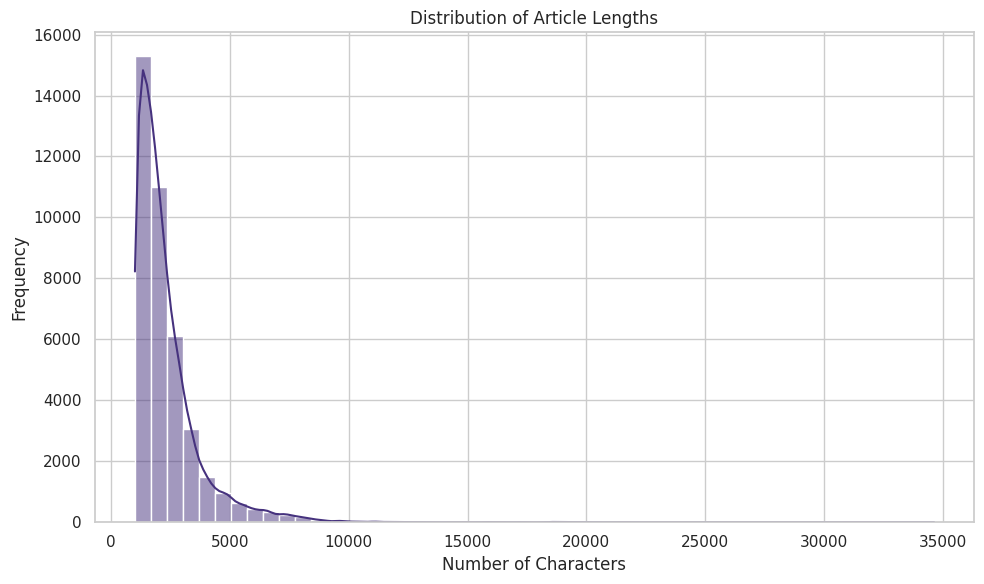

In [41]:
# Assume 'sampled_df' is your DataFrame
sampled_df['article_length'] = sampled_df['content'].apply(len)

# This single line sets a professional theme and color palette
sns.set_theme(style="whitegrid", palette="viridis")

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(data=sampled_df, x='article_length', bins=50, kde=True)

# Add titles and labels
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [16]:
# Step 3: Encode labels
le = LabelEncoder()
sampled_df['label'] = le.fit_transform(sampled_df['category_bn'])

In [17]:
sampled_df['label'].unique()

array([1, 4, 6, 2, 0, 7, 3, 5, 8])

In [18]:
sampled_df['label'].value_counts()

,count
label,
4,21699
2,4884
1,3031
6,2929
7,2108
0,1641
3,1332
8,1230
5,1146


In [19]:
from google.colab import files
uploaded = files.upload()

Saving NotoSansBengali-VariableFont_wdth,wght.ttf to NotoSansBengali-VariableFont_wdth,wght.ttf


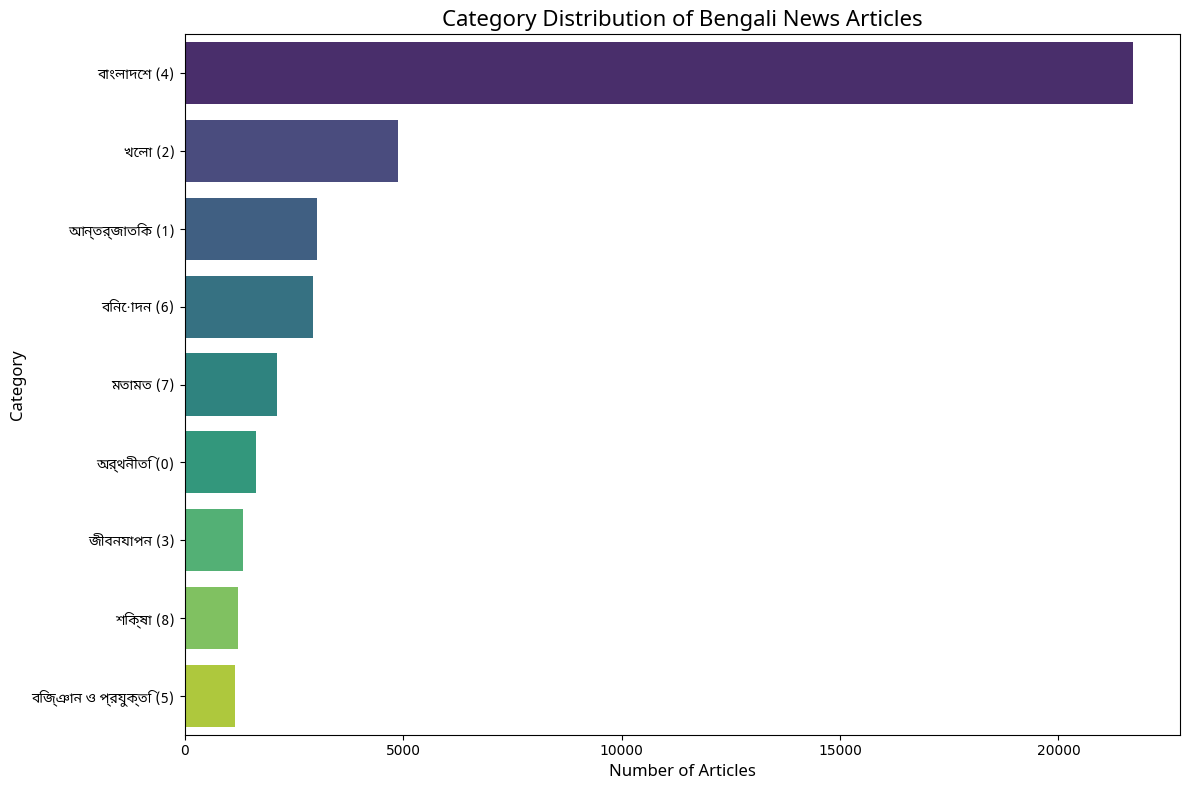

In [29]:
# 1. Define the path to your font and create a FontProperties object
font_path = 'NotoSansBengali-VariableFont_wdth,wght.ttf'
bengali_font = FontProperties(fname=font_path)

plt.figure(figsize=(12, 8))

order = sampled_df['label'].value_counts().index
label_to_category_bn = sampled_df.set_index('label')['category_bn'].to_dict()
new_labels = [f"{label_to_category_bn[label]} ({label})" for label in order]

ax = sns.countplot(
    data=sampled_df,
    y='label',
    order=order,
    palette='viridis'
)
ax.set_yticklabels(new_labels, fontproperties=bengali_font)

# Set titles and labels, also using the Bengali font where needed
plt.title('Category Distribution of Bengali News Articles', fontproperties=bengali_font, fontsize=16)
plt.xlabel('Number of Articles', fontproperties=bengali_font, fontsize=12)
plt.ylabel('Category', fontproperties=bengali_font, fontsize=12)

plt.tight_layout()
plt.show()

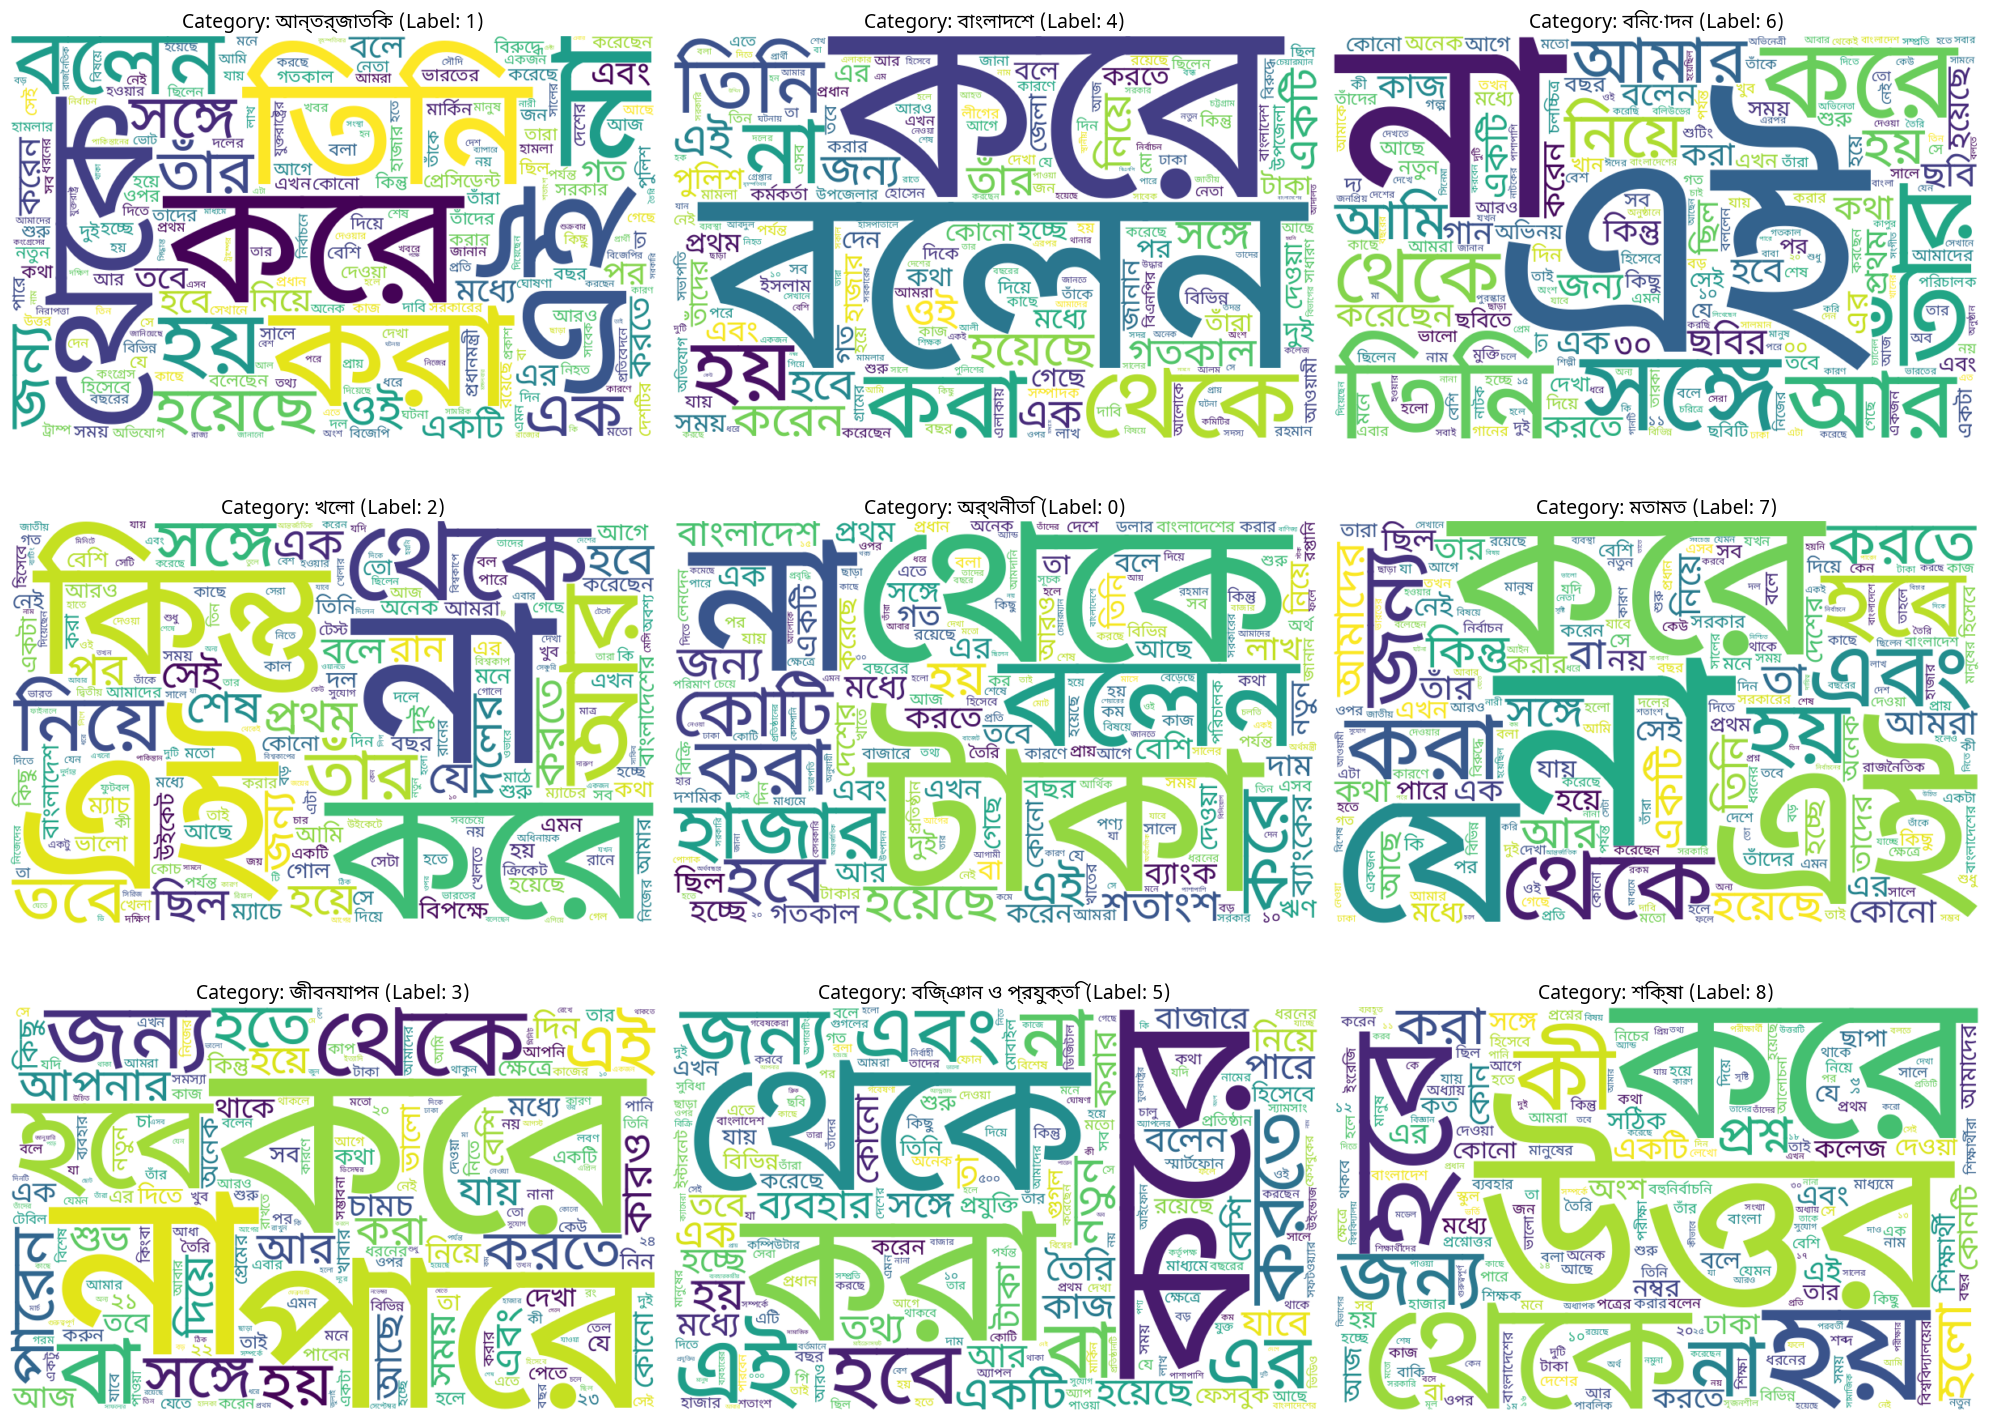

In [25]:
# Define the path to your font file
font_path = 'NotoSansBengali-VariableFont_wdth,wght.ttf'

# Create a FontProperties object
bengali_font = FontProperties(fname=font_path)

categories = sampled_df['category_bn'].unique()
plt.figure(figsize=(20, 15))

for i, category in enumerate(categories, 1):
    text = " ".join(sampled_df[sampled_df['category_bn'] == category]['content'])
    words = re.findall(r'[\u0980-\u09FF]+', text)
    filtered_words = [word for word in words if len(word) > 1]
    word_frequencies = Counter(filtered_words)

    label_num = sampled_df[sampled_df['category_bn'] == category]['label'].iloc[0]

    wordcloud = WordCloud(
        font_path=font_path,
        width=800, height=500,
        background_color='white'
    ).generate_from_frequencies(word_frequencies)

    plt.subplot(3, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    # --- Apply the font to the title ---
    title_text = f'Category: {category} (Label: {label_num})'
    plt.title(title_text, fontproperties=bengali_font, fontsize=14) # <-- Key change here!

plt.tight_layout()
plt.show()

In [22]:
# Save the fitted LabelEncoder to a file
joblib.dump(le, "label_encoder.pkl")
print("Label encoder saved as label_encoder.pkl")

Label encoder saved as label_encoder.pkl


In [23]:
# Step 5: Split the raw text and labels first (not tokenized tensors)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    sampled_df['content'].tolist(),
    sampled_df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=sampled_df['label']
)

In [24]:
# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained("sagorsarker/bangla-bert-base")

vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [25]:
# Tokenize train and validation separately
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding='max_length',
    max_length=256,
    return_tensors='pt'
)

In [26]:
val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding='max_length',
    max_length=256,
    return_tensors='pt'
)

In [27]:
# Create Dataset class
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [28]:
# Create datasets
train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

In [29]:
# Step 6: Load model with classification head
num_labels = len(sampled_df['label'].unique())
model = BertForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=num_labels)

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# Step 7: Define metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [31]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy='epoch',
    save_strategy='epoch',
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_total_limit=2,
    seed=42
)

In [32]:
# Step 8: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [33]:
# Train the model
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: croesusgamingv2 (croesusgamingv2-north-south-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.317600,0.299712,0.907500,0.907192,0.908387,0.907500
2,0.242100,0.337268,0.913750,0.913290,0.915259,0.913750


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.317600,0.299712,0.907500,0.907192,0.908387,0.907500
2,0.242100,0.337268,0.913750,0.913290,0.915259,0.913750
3,0.115600,0.400676,0.920500,0.920429,0.920562,0.920500


TrainOutput(global_step=6000, training_loss=0.24391115697224935, metrics={'train_runtime': 5009.5057, 'train_samples_per_second': 19.164, 'train_steps_per_second': 1.198, 'total_flos': 1.2630124412928e+16, 'train_loss': 0.24391115697224935, 'epoch': 3.0})

In [38]:
# Evaluate on validation dataset
eval_results = trainer.evaluate()

print("Evaluation results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

Evaluation results:
eval_loss: 0.4007
eval_accuracy: 0.9205
eval_f1: 0.9204
eval_precision: 0.9206
eval_recall: 0.9205
eval_runtime: 111.1391
eval_samples_per_second: 71.9820
eval_steps_per_second: 4.4990
epoch: 3.0000


In [39]:
# Specify directory where to save
save_directory = "./bangla_bert_news_classifier"

# Save model
model.save_pretrained(save_directory)

# Save tokenizer
tokenizer.save_pretrained(save_directory)

('./bangla_bert_news_classifier/tokenizer_config.json',
 './bangla_bert_news_classifier/special_tokens_map.json',
 './bangla_bert_news_classifier/vocab.txt',
 './bangla_bert_news_classifier/added_tokens.json',
 './bangla_bert_news_classifier/tokenizer.json')

In [40]:
# Step 1: Predict on validation set
predictions_output = trainer.predict(val_dataset)

In [41]:
# Get predicted class indices
y_pred = np.argmax(predictions_output.predictions, axis=1)

# True labels
y_true = predictions_output.label_ids

In [42]:
# Step 2: Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

Classification Report:

                     precision    recall  f1-score   support

           অর্থনীতি       0.76      0.77      0.77       328
        আন্তর্জাতিক       0.90      0.87      0.89       606
               খেলা       0.98      0.98      0.98       977
           জীবনযাপন       0.77      0.84      0.81       266
           বাংলাদেশ       0.95      0.95      0.95      4340
বিজ্ঞান ও প্রযুক্তি       0.83      0.79      0.81       229
             বিনোদন       0.91      0.90      0.90       586
              মতামত       0.80      0.78      0.79       422
             শিক্ষা       0.91      0.87      0.89       246

           accuracy                           0.92      8000
          macro avg       0.87      0.86      0.87      8000
       weighted avg       0.92      0.92      0.92      8000



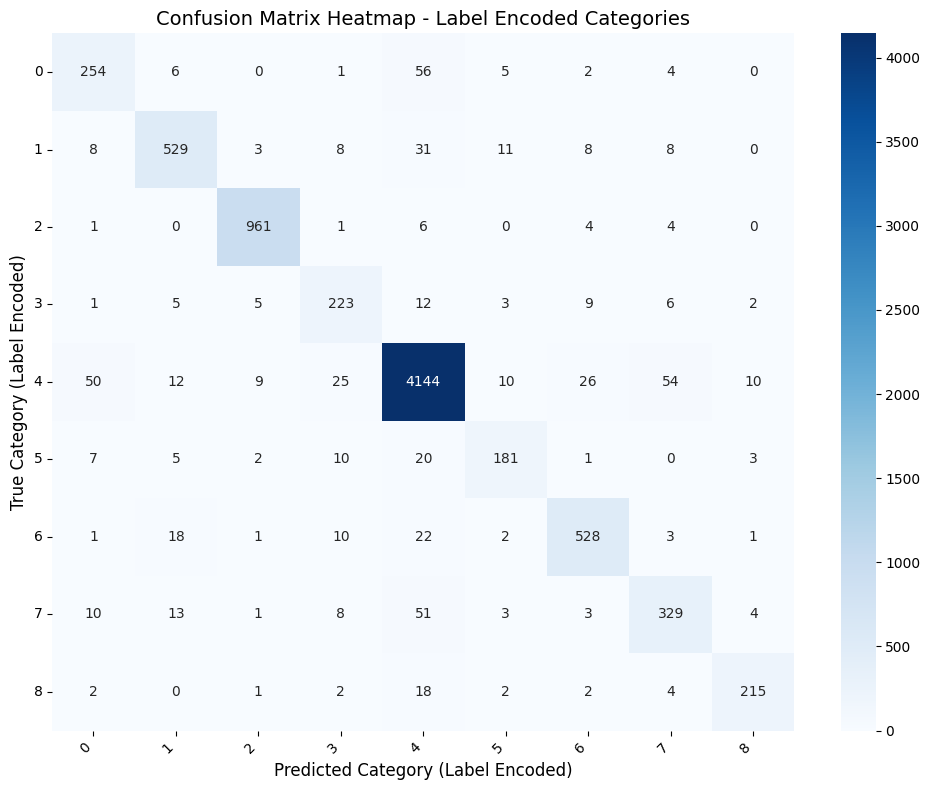

In [45]:
# Example: Assuming y_true and y_pred are already available
cm = confusion_matrix(y_true, y_pred)

# Get numeric labels instead of Bengali text
categories_num = list(range(len(le.classes_)))  # 0, 1, 2, ...

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=categories_num,
    yticklabels=categories_num
)

plt.xlabel('Predicted Category (Label Encoded)', fontsize=12)
plt.ylabel('True Category (Label Encoded)', fontsize=12)
plt.title('Confusion Matrix Heatmap - Label Encoded Categories', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

In [46]:
# Load pretrained multilingual summarization model and tokenizer
model_name = "csebuetnlp/mT5_multilingual_XLSum"  # good for Bengali summarization
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

In [47]:
# Example Bengali news text (replace with your own content)
sample_text = sampled_df['content'].iloc[0]

In [48]:
# Prepend task prefix if needed (depends on model, XLSum needs "summarize: " prefix)
input_text = "summarize: " + sample_text

In [49]:
# Tokenize input
inputs = tokenizer(input_text, max_length=512, truncation=True, return_tensors="pt")

In [50]:
# Generate summary (you can tweak parameters like max_length and num_beams)
summary_ids = model.generate(
    inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    max_length=100,
    num_beams=4,
    early_stopping=True
)

In [51]:
# Decode and print summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Original:", sample_text[:500], "...\n")
print("Summary:", summary)

Original: আড়াই কোটি ডলারের বিনিময়ে মার্কিন প্রেসিডেন্ট নির্বাচনে রিপাবলিকান দলের বিজয়ী প্রার্থী ডোনাল্ড ট্রাম্প তাঁর ট্রাম্প বিশ্ববিদ্যালয়ের বিরুদ্ধে করা তিনটি প্রতারণার মামলা সুরাহা করেছেন। নিউইয়র্কের অ্যাটর্নি জেনারেল এরিক স্নেইডারম্যান গত শুক্রবার এক বিবৃতিতে এ তথ্য জানিয়েছেন।ট্রাম্প বিশ্ববিদ্যালয়ের কয়েকজন প্রাক্তন শিক্ষার্থী মামলাগুলো করেছিলেন। তাঁদের অভিযোগ, বিশ্ববিদ্যালয়টি প্রতিশ্রুতি রক্ষা করতে পারেনি এবং তাঁদের ভুল শিখিয়েছে। আবাসন ব্যবসার ‘গোপন রহস্য’ ফাঁস করার প্রলোভন দেখিয়ে ‘নিজের নির্বাচিত’ প্র ...

Summary: মার্কিন প্রেসিডেন্ট নির্বাচনে রিপাবলিকান দলের বিজয়ী প্রার্থী ডোনাল্ড ট্রাম্প আড়াই কোটি ডলারের বিনিময়ে নিউইয়র্ক বিশ্ববিদ্যালয়ের বিরুদ্ধে করা তিনটি প্রতারণার মামলা সুরাহা করেছেন।


In [ ]:
# Code for Integrated Classification + Summarization Pipeline

In [52]:
# Load classification model and tokenizer
clf_tokenizer = BertTokenizerFast.from_pretrained("sagorsarker/bangla-bert-base")
clf_model = BertForSequenceClassification.from_pretrained('./bangla_bert_news_classifier')
clf_model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [53]:
# Load summarization model and tokenizer
sum_model_name = "csebuetnlp/mT5_multilingual_XLSum"
sum_tokenizer = AutoTokenizer.from_pretrained(sum_model_name)
sum_model = AutoModelForSeq2SeqLM.from_pretrained(sum_model_name)
sum_model.eval()

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

In [54]:
# Save them to a local folder
local_path = "mt5_bengali_summarizer"
sum_tokenizer.save_pretrained(local_path)
sum_model.save_pretrained(local_path)

print(f"Model saved at {local_path}")

Model saved at mt5_bengali_summarizer


In [55]:
# Load label encoder classes (you should save label encoder classes during training)
# Here assuming you saved classes in a list:
label_classes = le.classes_  # from previous LabelEncoder training

In [56]:
def classify_news(text):
    inputs = clf_tokenizer(text, truncation=True, padding='max_length', max_length=256, return_tensors='pt')
    with torch.no_grad():
        outputs = clf_model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    return label_classes[predicted_class_id]

In [57]:
def summarize_news(text):
    input_text = "summarize: " + text
    inputs = sum_tokenizer(input_text, max_length=512, truncation=True, return_tensors="pt")
    with torch.no_grad():
        summary_ids = sum_model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=100,
            num_beams=4,
            early_stopping=True
        )
    summary = sum_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [58]:
# Example usage:
news_article = "ফিলিস্তিনিদের অস্ত্র দেওয়ার কাজে গতি বাড়াবে তেহরান। ইরানের আকাশসীমায় ইসরায়েলি চালকবিহীন বিমান (ড্রোন) মোতায়েন করার পাল্টা ব্যবস্থা হিসেবে এ পদক্ষেপ নেওয়া হবে। ইরানের একজন সামরিক কমান্ডার গতকাল সোমবার এ কথা বলেছেন।এদিকে গাজার বিভিন্ন এলাকায় গতকালও বিমান হামলা চালিয়েছে ইসরায়েল। এতে আরও চার ফিলিস্তিনির মৃত্যু হয়েছে। এ নিয়ে ১৯ আগস্ট অস্ত্রবিরতি ভেঙে পড়ার পর ৩৫০টির বেশি ইসরায়েলি বিমান হামলায় ১০৬ ফিলিস্তিনির প্রাণহানি ঘটল। একই সময়ে গাজা থেকে অন্তত ৬৫০টি রকেট ইসরায়েলে ছোড়া হয়েছে, যার মধ্যে একটির আঘাতে এক ইসরায়েলি কিশোরের মৃত্যু হয়েছে।ইরানের অভিজাত রেভল্যুশনারি গার্ডের দাপ্তরিক ওয়েবসাইটে প্রকাশিত এক বিবৃতিতে তাদের বিমানবাহিনীর কমান্ডার জেনারেল আমির আলী হাজিজেদাহ বলেন, ‘আমরা পশ্চিম তীরকে (ফিলিস্তিনের) অস্ত্রসজ্জিত করার কাজে গতি বাড়াব এবং যেকোনো ধরনের জবাব দেওয়ার অধিকার আমাদের রয়েছে।’ফিলিস্তিনের গাজায় গত ৮ জুলাই বিমান হামলা শুরু করে ইসরায়েল। এরপর গাজা শাসনকারী ইসলামপন্থী গ্রুপ হামাস ও ইসলামিক জিহাদ ইসরায়েলের ভেতরে যেসব রকেট নিক্ষেপ করেছে, তার প্রযুক্তি ইরান সরবরাহ করেছে বলে নিশ্চিত করেছে তেহরান।ফিলিস্তিনি যোদ্ধাদের অস্ত্র দেওয়ার গতি আরও বাড়ানো হবে বলে ইরানের এ হুমকির এক দিন আগে দেশটির রেভল্যুশনারি গার্ড জানায়, তারা ইরানের আকাশসীমায় ঢুকে পড়া একটি ইসরায়েলি ড্রোন ভূপাতিত করেছে। স্টিলথ প্রযুক্তির ‘হার্মেস’ ড্রোনটি ইরানের মধ্যাঞ্চলে অবস্থিত নাতাঞ্জ ইউরেনিয়াম সমৃদ্ধকরণ কেন্দ্রের কাছে ভূপাতিত করা হয়। ড্রোনটির খণ্ডগুলো অক্ষত অবস্থায় পাওয়া গেছে। সেগুলো পরীক্ষা করে দেখা হচ্ছে।মিসরের নতুন প্রস্তাব: মিসরের মধ্যস্থতাকারীরা ইসরায়েল-হামাস অস্ত্রবিরতির জন্য নতুন একটি প্রস্তাব দিয়েছে, যেখানে আট বছর ধরে অবরুদ্ধ গাজার বেশ কিছু ক্রসিং খুলে দেওয়া এবং ত্রাণ ও নির্মাণসামগ্রী যাওয়ার অনুমতি দেওয়ার কথা বলা হয়েছে। একজন জ্যেষ্ঠ ফিলিস্তিনি কর্মকর্তা গতকাল এ কথা জানান। ইসরায়েল মানলে হামাসসহ ফিলিস্তিনিরাও এ ধরনের প্রস্তাব মানবে বলে ইঙ্গিত দেন তিনি।"

In [59]:
category = classify_news(news_article)
summary = summarize_news(news_article)

print(f"Category: {category}")
print(f"Summary: {summary}")

Category: আন্তর্জাতিক
Summary: ফিলিস্তিনি যোদ্ধাদের অস্ত্র দেওয়ার গতি আরও বাড়ানো হবে বলে ইরানের সরকার জানিয়েছে।


In [60]:
# Example usage:
news_article = "সর্বশেষ ওয়ানডেটি খেলেছিলেন গত বছরের ডিসেম্বরে। ইনজুরির কারণে বাংলাদেশের জিম্বাবুয়ে সফরেও দলে ছিলেন না দলের প্রধান পেসার মাশরাফি বিন মুর্তজা। তবে সব ঠিক থাকলে নিউজিল্যান্ডের বিপক্ষে ওয়ানডে সিরিজটাতেই আবার দলে ফিরতে পারেন এই ডানহাতি পেসার। আজ ওয়ানডে সিরিজের জন্য ঘোষিত ২৮ সদস্যের প্রাথমিক দলে জায়গা করে নিয়েছেন মাশরাফি।দীর্ঘদিন মাঠের বাইরে কাটাতে হলেও আবার যে ফেরার জন্য প্রস্তুত হয়েছেন, ঘরোয়া ক্রিকেটে সেটার ইঙ্গিত বেশ ভালোমতোই দিয়েছেন মাশরাফি। ঢাকা প্রিমিয়ার ডিভিশনে মোহামেডানের হয়ে তিন ম্যাচ খেলে নিয়েছেন সাতটি উইকেট। ঘরোয়া ক্রিকেটে ভালো পারফরম্যান্স দেখিয়ে প্রথমবারের মতো জাতীয় দলে ডাক পেয়েছেন আল আমিন। চার ম্যাচে ১৪টি উইকেট নিয়ে সর্বোচ্চ উইকেটশিকারির তালিকায় দ্বিতীয় স্থানে আছেন আবাহনীর এই ডানহাতি পেসার।প্রাথমিক এই দল ঘোষণা ছাড়াও বেশ কিছু গুরুত্বপূর্ণ সিদ্ধান্ত নেওয়া হয়েছে বাংলাদেশ ক্রিকেট বোর্ডের নির্বাহী কমিটির সভায়। গ্রহণ করা হয়েছে প্রধান নির্বাচক আকরাম খানের পদত্যাগপত্র। অন্যদিকে নির্বাচক কমিটির সদস্য মিনহাজুল আবেদীন ও হাবিবুল বাশারের সঙ্গে চুক্তির মেয়াদ বাড়ানো হয়েছে আগামী বছরের ৩০ জুন পর্যন্ত। নিউজিল্যান্ডের বিপক্ষে ওয়ানডে সিরিজটির জন্য জাতীয় দলের ম্যানেজার হিসেবে নিয়োগ দেওয়া হয়েছে সাবেক অধিনায়ক নাঈমুর রহমানকে।২৮ সদস্যের প্রাথমিক দল: মুশফিকুর রহিম, মাহমুদউল্লাহ, এনামুল হক, তামিম ইকবাল, সাকিব আল হাসান, নাসির হোসেন, মোহাম্মদ ইলিয়াস, জিয়াউর রহমান, মাশরাফি বিন মুর্তজা, জহুরুল ইসলাম, শফিউল ইসলাম, আবদুর রাজ্জাক, নাঈম ইসলাম, সোহাগ গাজী, রুবেল হোসেন, মুমিনুল হক, শামসুর রহমান, মার্শাল আইয়ুব, রবিউল ইসলাম, ফরহাদ রেজা, মেহরাব হোসেন, সাজেদুল ইসলাম, আল আমিন, এনামুল হক (জুনিয়র), সৌম্য সরকার, সাব্বির রহমান, মুক্তার আলি ও নূর হোসেন।"

In [61]:
category = classify_news(news_article)
summary = summarize_news(news_article)

print(f"Category: {category}")
print(f"Summary: {summary}")

Category: খেলা
Summary: বাংলাদেশ ক্রিকেট বোর্ড নিউজিল্যান্ডের বিপক্ষে ওয়ানডে সিরিজের জন্য প্রাথমিক দল ঘোষণা করেছে।
